<a href="https://colab.research.google.com/github/TheDuyIT/MachineTranslation/blob/master/src/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q tfds-nightly
# !pip install tensorflow-gpu

In [7]:
!npx degit TheDuyIT/MachineTranslation -f

npx: installed 1 in 0.73s
> destination directory is not empty. Using --force, continuing
> cloned TheDuyIT/MachineTranslation#master


In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
import tensorflow_datasets as tfds
import tensorflow as tf
import unicodedata
import time
import re
import numpy as np
import matplotlib.pyplot as plt
from src.process_data import DataFormatter, DataLoader

## Setup input pipeline

In [10]:
loader = DataLoader()

In [12]:
content_en = loader.np_load('lst_cn_all_except_1001')
content_vn = loader.np_load('lst_vi_all_except_1001')
for i in range(len(content_vn)):
  content_vn[i] = content_vn[i].lower()
  # content_en.append(i['en'].lower())
  # content_vn.append(i['vn'].lower())

In [13]:
print(len(content_en))
print(len(content_vn))

8376
8376


In [14]:
a = tf.data.Dataset.from_tensor_slices(content_en)  # ==> [ 1, 2, 3 ]
b = tf.data.Dataset.from_tensor_slices(content_vn)  # ==> [ 4, 5, 6 ]

full_dataset = tf.data.Dataset.zip((a, b))

In [15]:
train_size = int(0.8*0.9*len(full_dataset)) + 2
val_size = int(0.8*0.1*len(full_dataset))
test_size = int(0.2*len(full_dataset))

In [16]:
full_dataset = full_dataset.shuffle(buffer_size = 1000)
train_examples = full_dataset
test_dataset = full_dataset
val_dataset = full_dataset
# train_examples = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [17]:
# tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_en')
# tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_vn')
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for en, _ in train_examples), target_vocab_size=2**13)

tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (vn.numpy() for _, vn in train_examples), target_vocab_size=2**13)

In [18]:
# tokenizer_en.save_to_file('/content/drive/MyDrive/VinBigData/checkpoints/tokenizer_en')
# tokenizer_vn.save_to_file('/content/drive/MyDrive/VinBigData/checkpoints/tokenizer_vn')

In [19]:
BUFFER_SIZE = 2000
BATCH_SIZE = 128

In [20]:
def encode(lang1, lang2):
  lang1 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang1.numpy()) + [tokenizer_en.vocab_size+1]

  lang2 = [tokenizer_vn.vocab_size] + tokenizer_vn.encode(
      lang2.numpy()) + [tokenizer_vn.vocab_size+1]
  
  return lang1, lang2

In [21]:
def tf_encode(en, vn):
  result_en, result_vn = tf.py_function(encode, [en, vn], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_vn.set_shape([None])

  return result_en, result_vn

In [22]:
MAX_LENGTH = 190


In [23]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [24]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_dataset.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

test_dataset = test_dataset.map(tf_encode)
test_dataset = test_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [25]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [26]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


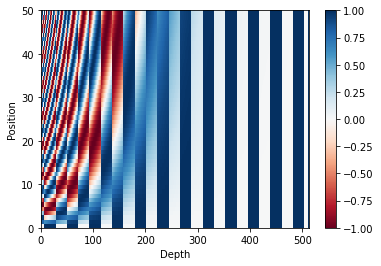

In [27]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [28]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [29]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [30]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## Multi-head attention

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [32]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [33]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [35]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [36]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

In [37]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()
    
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
    
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

## Set hyperparameters

In [38]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_vn.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [40]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [41]:
from nltk.translate.bleu_score import sentence_bleu
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def accuracy_function(real, pred):
  # print('000000000000000000000000000')
  # print(real)
  # print('111111111111111111111111111')
  # print(pred)
  # print('222222222222222222222222222')
  # print(tf.argmax(pred, axis=2))
  # print('333333333333333333333333333')

  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  # print(accuracies)
  # print('333333333333333333333333333')
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
# def accuracy_function(real, pred):
#   candidate = tf.argmax(pred, axis=2)
#   # print(real.)
#   print(real.numpy()[0][:-1])
#   print(tokenizer_vn.decode(real.numpy()[0][:-1]))
#   print(candidate.numpy()[0][:-1])
#   print(tokenizer_vn.decode(candidate.numpy()[0][:-1]))
#   # print(candidate)
#   # score = bleu_score(real, candidate)
#   score = 12
#   print(score)
#   return tf.constant(score)
# # bleu_function('real', 'pred')


In [42]:
# dir(tokenizer_vn)

In [43]:
# for i in content_vn[:12]:
#   if 'mãnh_' in i:
#     print(i)  

In [44]:
# for i in range(100000):
#   print(tokenizer_vn._id_to_subword(i).encode('utf-8').decode('utf-8'))

In [45]:
from collections import Counter
import math
def n_gram_generator(sentence,n= 2,n_gram= False):
    '''
    N-Gram generator with parameters sentence
    n is for number of n_grams
    The n_gram parameter removes repeating n_grams 
    '''
    sentence = sentence.lower() # converting to lower case
    sent_arr = np.array(sentence.split()) # split to string arrays
    length = len(sent_arr)

    word_list = []
    for i in range(length+1):
        if i < n:
            continue
        word_range = list(range(i-n,i))
        s_list = sent_arr[word_range]
        string = ' '.join(s_list) # converting list to strings
        word_list.append(string) # append to word_list
        if n_gram:
            word_list = list(set(word_list))
    return word_list
def bleu_score(original,machine_translated):
    '''
    Bleu score function given a orginal and a machine translated sentences
    '''
    mt_length = len(machine_translated.split())
    o_length = len(original.split())

    # Brevity Penalty 
    if mt_length>o_length:
        BP=1
    else:
        penality=1-(mt_length/o_length)
        BP=np.exp(penality)

    # Clipped precision
    clipped_precision_score = []
    for i in range(1, 5):
        original_n_gram = Counter(n_gram_generator(original,i))
        machine_n_gram = Counter(n_gram_generator(machine_translated,i))

        c = sum(machine_n_gram.values())
        for j in machine_n_gram:
            if j in original_n_gram:
                if machine_n_gram[j] > original_n_gram[j]:
                    machine_n_gram[j] = original_n_gram[j]
            else:
                machine_n_gram[j] = 0

        #print (sum(machine_n_gram.values()), c)
        clipped_precision_score.append(sum(machine_n_gram.values())/c)

    #print (clipped_precision_score)

    weights =[0.25]*4

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = BP * math.exp(math.fsum(s))
    return s

original = "It is a guide to action which ensures that the military alwasy obeys the command of the party"
machine_translated = "It is the guiding principle which guarantees the military forces alwasy being under the command of the party"

print (bleu_score(original, machine_translated))
print (sentence_bleu([original.split()], machine_translated.split()))

0.27098211583470044
0.27098211583470044


In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(
    name='train_accuracy')

## Training and checkpointing

In [47]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [48]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [49]:
checkpoint_path = "/content/drive/MyDrive/VinBigData/checkpoints/train1"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [50]:
EPOCHS = 0

In [51]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths o4/1AY0e-g5NwERYfvXHd5gYJ0PO1FU94gGYrmyMq14BU0Dlvo5oiSqu1suLElor variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# @tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  # print('inner train')
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    # print('---------------------------------')
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  # print('--------------------')
  # print(accuracy_function(tar_real, predictions))
  # print('--------------------')
  train_accuracy(accuracy_function(tar_real, predictions))

In [52]:
EPOCHS = 100
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> en, tar -> vn
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.3686 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.2930 Accuracy 0.0243
Epoch 1 Loss 8.2540 Accuracy 0.0444
Time taken for 1 epoch: 27.72817087173462 secs

Epoch 2 Batch 0 Loss 8.1519 Accuracy 0.0538
Epoch 2 Batch 50 Loss 7.9951 Accuracy 0.0822
Epoch 2 Loss 7.9518 Accuracy 0.0886
Time taken for 1 epoch: 21.233047485351562 secs

Epoch 3 Batch 0 Loss 7.8496 Accuracy 0.0440
Epoch 3 Batch 50 Loss 7.6209 Accuracy 0.0838
Epoch 3 Loss 7.5671 Accuracy 0.0900
Time taken for 1 epoch: 21.055925130844116 secs

Epoch 4 Batch 0 Loss 7.3813 Accuracy 0.0504
Epoch 4 Batch 50 Loss 7.1294 Accuracy 0.0839
Epoch 4 Loss 7.0790 Accuracy 0.0900
Time taken for 1 epoch: 20.95382523536682 secs

Epoch 5 Batch 0 Loss 6.7852 Accuracy 0.0608
Epoch 5 Batch 50 Loss 6.6319 Accuracy 0.0839
Saving checkpoint for epoch 5 at /content/drive/MyDrive/VinBigData/checkpoints/train1/ckpt-1
Epoch 5 Loss 6.6025 Accuracy 0.0895
Time taken for 1 epoch: 21.63756561279297 secs

Epoch 6 Batch 0 Loss 6.3609 Accuracy 0.0

## Evaluate

In [53]:
import time
from tqdm import tqdm
def evaluate(inp_sentence):
  start_token = [tokenizer_en.vocab_size]
  end_token = [tokenizer_en.vocab_size + 1]
  
  # inp sentence is eng, hence adding the start and end token
  inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is vn, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_vn.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_vn.vocab_size+1:
      
      return tf.squeeze(output, axis=0), attention_weights

      
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [54]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  predicted_sentence = tokenizer_vn.decode([i for i in result 
                                            if i < tokenizer_vn.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [55]:
print(translate('你好！'))

Input: 你好！
Predicted translation: chào bạn!
None


In [56]:
print(translate('我爱你')) # anh yêu em

Input: 我爱你
Predicted translation: yêu cậu chẳng cần lý do
None


In [57]:
print(translate('听说越南的杂技很有意思，我还没看过呢。'))

Input: 听说越南的杂技很有意思，我还没看过呢。
Predicted translation: nghe nói xiếc của việt nam rất thú vị, tôi vẫn chưa xem qua.
None


In [58]:
print(translate('你来过越南吗？你来越南以后去过什么地方？'))

Input: 你来过越南吗？你来越南以后去过什么地方？
Predicted translation: bạn đã từng đến việt nam chưa? sau khi bạn tới việt nam đã từng đến nơi nào?
None


In [59]:
print(translate('我是越南人')) # tôi là người VN

Input: 我是越南人
Predicted translation: tôi là người việt nam
None


In [60]:
print(translate('我不是越南人')) # tôi không là người VN

Input: 我不是越南人
Predicted translation: không phải em xứng trẻ
None


In [61]:
print(translate('他是中国人')) # anh ta là người Trung Quốc

Input: 他是中国人
Predicted translation: anh là người nước mắt
None


In [62]:
print(translate('越南北部的中国')) # Trung Quốc ở phía bắc Việt Nam

Input: 越南北部的中国
Predicted translation: việt nam là cô, em gái tôi làm quen với văn hóa việt nam.
None


In [63]:
print(translate('明天我哥哥很忙。'))

Input: 明天我哥哥很忙。
Predicted translation: ngày mai anh trai tôi rất bận.
None


In [64]:
print(translate('那是英文杂志。'))

Input: 那是英文杂志。
Predicted translation: kia là tạp chí tiếng anh?
None


In [65]:
print(translate('明天下了课我就去办公室找她。'))

Input: 明天下了课我就去办公室找她。
Predicted translation: ngày mai tan học xong tôi sẽ đến văn phòng tìm cô ta.
None


In [71]:
print(translate('真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。'))

Input: 真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。
Predicted translation: thất bại thật sự không phải là kết quả không được như ý muốn mà là khi ta đang nắm giữ trong tay nhưng không biết trân trọng mà lại tùy tiện và dễ dàng từ bỏ khi chưa nếm trải qua hay quyết tâm giữ lấy.
None


In [70]:
print(translate('真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。'))

Input: 真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。
Predicted translation: thất bại thật sự không phải là kết quả không được như ý muốn mà là khi ta đang nắm giữ trong tay nhưng không biết trân trọng mà lại tùy tiện và dễ dàng từ bỏ khi chưa nếm trải qua hay quyết tâm giữ lấy.
None


In [67]:
print(translate('你的名字写下来不过几厘米长，却贯穿了我这么长时光。其实你不知道，你一直是我的梦想。'))


Input: 你的名字写下来不过几厘米长，却贯穿了我这么长时光。其实你不知道，你一直是我的梦想。
Predicted translation: tên của anh khi giọt nước mắt rơi xuống là mua, làm là giản như vậy. nhưng những gì có thể dùng hàng 1000 cái hương thơm của anh cười của em. thực ra không cười bật đèn xanh chỉ cần rẽ ngang từng yêu phạm sai lầm: thực hiện thực hiện trong tim cũng sa mạc khiến cho ước mơ màng ấy chỉ có mà chỉ có bản thân những lời yêu cầu tính lên. cho dù có bản thân yêu thích vô cùng hoa.
None


In [77]:
print(translate('写给自己的第二封信 人生，总会有不期而遇的温暖，和生生不息的希望。不管前方的路有多苦，只要走的方向正确，不管多么崎岖不平，都比站在原地更接近幸福。'))

Input: 写给自己的第二封信 人生，总会有不期而遇的温暖，和生生不息的希望。不管前方的路有多苦，只要走的方向正确，不管多么崎岖不平，都比站在原地更接近幸福。
Predicted translation: đời người luôn có những điều ấm áp không mong mà tới, và cả những hi vọng không ngừng lớn lên. cho dù con đường phía trước có bao nhiêu khổ ải, chỉ cần hướng đi đúng thì dù trên đường đi có bao nhiêu chông gai gập ghềnh cũng còn gần với bến bờ hạnh phúc hơn chỉ đứng mãi ở vạch xuất phát.
None


In [79]:
print(translate('如果你感到委屈，证明你还有底线；如果你感到迷茫，证明你还有追求；如果你感到痛苦，证明你还有力气；如果你感到绝望，证明你还要希望。 从某种意义上，你永远都不会被打倒，因为你还有你。'))

Input: 如果你感到委屈，证明你还有底线；如果你感到迷茫，证明你还有追求；如果你感到痛苦，证明你还有力气；如果你感到绝望，证明你还要希望。 从某种意义上，你永远都不会被打倒，因为你还有你。
Predicted translation: nếu như bạn cảm thấy oan ức thì chứng tỏ bạn vẫn còn giới hạn. nếu như bạn cảm thấy mông lung lạc lối chứng tỏ bạn vẫn còn nhiều điều muốn theo đuổi. nếu như bạn cảm thấy đau khổ chứng tỏ bạn vẫn còn sức lực. nếu như bạn cảm thấy tuyệt vọng chứng tỏ bạn vẫn còn hy vọng. trên một tầng ý nghĩa nào đó, bạn vĩnh viễn sẽ không bị bất cứ điều gì đạp đổ bởi vì bạn vẫn còn bản thân mình.
None


In [80]:
print(translate('今天我的工作不太忙。'))

Input: 今天我的工作不太忙。
Predicted translation: hôm nay công việc của tôi không bận lắm.
None
